In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

In [3]:
# general setup
time_steps = 50 

#special PATs, user specific
spPAT = 3
# 'vote' -
# 'reputation' -
# 'governance' -

#PAT attributes, PAT specific
PAT_atr = True
PAT_flav = True
#flavour - good [0, 5] - bad [6, 10] - randomly distributed
# users are good [1, 5]
good_users = 50 #%
# users are bad [6, 10]
bad_users = 20 #%
# users are ignorant [4, 7]
ignorant_users = 30 #%

# 'difficulty' 
PAT_diff_constant = False
PAT_controlled = True
good_PAT = 5
ignorant_PAT = 2
bad_PAT = 1

PAT_atr_max = False # not yet implemented
# 'max' -
# 'value' -

#population settings
community = True
community_size_1 = 35
community_series = False
# not implemented yet
community_size_2 = 0 
# not implemented yet
between_com = 0      

#TCR settings - only voting implemented 
TCR = False            
reputation_threshold_for_voting = 0 # reputation tokens
voting_rate = False    # not imnplemented yet
voting_rate_value = 20 #% not implemented yet

#reputation token allocation

# for proof of positive action
rep_token_proof = False
# for claiming/receiving a token
rep_token_claim = False
rep_PAT_creator = False

#random OPATs
# the PATs are selected randomly for voting from the existing PAT list 
random_OPATs = False
# the selected PATs for voting are follow a fixed list of PAT ids
fixed_OPAT_sugestion = False
# the selected PATs from a fixed list become OPATs regardless of the vote results
fixed_OPATs = False


In [4]:
simulation_parameters = {
    'T': range(time_steps),
    'N': 1,
    'M': {}
}

In [5]:
def get_update_name(variable_name):
    return "add_" + variable_name

In [6]:
#general constants
TIMESTEP = 'timestep' # access to current timestep with s[TIMESTEP]
USERS = "users"
PATS = "pats"
PAT_ARGUMENTS = "pat_arguments"
OPATS = "opats"
WALLET_GAINS = "wallet_gains"
ADD_USERS = get_update_name(USERS)
ADD_PATS = get_update_name(PATS)

proposed_PAT_id = [5, 10, 15, 20, 25, 30, 35, 40]


In [7]:
if PAT_flav:
    initial_conditions = {
        USERS: {0:{}},  # users are numerical ids and a dictionary of their current wallet
        PATS: [0],      # pats are currently simply numerical ids
        PAT_ARGUMENTS: [(0, 1, 1)], # PAT specific atributes
        OPATS: ()
    }
else:
    initial_conditions = {
        USERS: {0:{}},  # users are numerical ids and a dictionary of their current wallet
        PATS: [0],      # pats are currently simply numerical ids
        PAT_ARGUMENTS: [(0, 1)], # PAT specific atributes
        OPATS: ()
    }

#### Secondary Functions

In [8]:
def clear_PAT_list(pats):
    print("pats", pats)
    for i in range(0, len(pats)-1):
        try:
            if pats[i] == "vote":
                del pats[i]

            if pats[i] == "reputation":
                del pats[i]

            if pats[i] == "governance":
                del pats[i]
        except:
            pass
    print("cleaned pats: ", pats)
    return pats

In [9]:
def pat_proposal(users):
    choice = None
    p = users[PATS].copy()
    op = users[OPATS]
    ch_list_1 = clear_PAT_list(p)

    if fixed_OPAT_sugestion:
        if users[TIMESTEP] % 5 != 0:
            pass
        else:
            choice = users[TIMESTEP]
    else:
        if len(op) > 0 and op[0] != None:
            if ch_list_1 != None:
                if len(ch_list_1) > 0:
                    ch_list = set(ch_list_1) - set(list(op))
                    choice = random.choice(list(ch_list))
            else:
                choice = None
        else:
            choice = random.choice(p)
    return choice


In [10]:
def vote_result(users):
    yes = 0
    no = 0
    for u in range(0, len(users)):
        if 'vote' in users[u]:
            if users[u].get("vote") == 0:
                no += 1
            if users[u].get("vote") == 1:
                yes += 1
        else:
            pass
    if no == 0 and yes == 0 or no == yes:
        vote = None
    elif no > yes:
        vote = False
    elif no < yes:
        vote = True
    return vote

In [11]:
def good_man(u, pats, arg, tstep, gain):
    print ("good man")
    good_PAT_list = []
    for pat in pats:  
        for i in arg:
            if i[0] == pat:
                if i[2] >= 1 and i[2] <= 3:
                    good_PAT_list.append(pat)

    for p in random.sample(good_PAT_list, random.randint(0, len(good_PAT_list))):
        for i in arg:
            if i[0] == p:
                if tstep % i[1] == 0:
                    gain[(u, p)] = 1
    print("good, gain: ", gain)
    return gain

In [12]:
def ignorant_man(u, pats, arg, tstep, gain):
    print ("ignorant man")
    ignorant_PAT_list = []
    for pat in pats: 
        for i in arg:
            if i[0] == pat:
                if i[2] >= 4 and i[2] <= 7:
                    ignorant_PAT_list.append(pat)
                    
    for p in random.sample(ignorant_PAT_list, random.randint(0, len(ignorant_PAT_list))):
        for i in arg:
            if i[0] == p:
                if tstep % i[1] == 0:
                    gain[(u, p)] = 1
    print("ignorant, gain: ", gain)
    return gain

In [13]:
def bad_man(u, pats, arg, tstep, gain):
    print ("bad man")
    bad_PAT_list = []
    for pat in pats:
        for i in arg:
            if i[0] == pat:
                if i[2] >= 7:
                    bad_PAT_list.append(pat)

    for p in random.sample(bad_PAT_list, random.randint(0, len(bad_PAT_list))):
        for i in arg:
            if i[0] == p:
                if tstep % i[1] == 0:
                    gain[(u, p)] = 1
    print("bad, gain: ", gain)
    return gain

In [14]:
def distribute_tokens_pat_attributes(s, gain, extra_gain):
    pats = s[PATS]
    p = pats[3:]
    users = s[USERS]
    tstep = s[TIMESTEP]
    arg = s[PAT_ARGUMENTS]
    print("arguments: ", arg)
    opats = s[OPATS]
    # at most all the PATs of a person get a token
    for u in users:
        # for each pat in a list of paths of random length and random values
        if arg[u][2] <= 3:
            good_man(u, pats, arg, tstep, gain)
            #print("good man")
        if arg[u][2] >= 4 and arg[u][2] <= 7:
            ignorant_man(u, pats, arg, tstep, gain)
            #print("ignorant man")
        if arg[u][2] >=8 and arg[u][2]<=10:
            bad_man(u, pats, arg, tstep, gain)
            #print("bad man")

In [15]:
def distribute_tokens(s, gain, extra_gain):
    users = s[USERS]
    pats = s[PATS]
    opats = s[OPATS]
    p = pats[3:]
    # at most all the PATs of a person get a token
    for u in users:
        # for each pat in a list of paths of random length and random values
        for pat in random.sample(p, random.randint(0, len(p))):
            gain[(u, pat)] = 1
        if opats != None:
            # if OPATs exist, every user will be allocated a token for each OPAT
            for opa in range(0, len(opats)):
                gain[(u, opats[opa])] = 1
    return gain


In [16]:
def get_rep_token(wallet, gain, n):
    if 'reputation' in wallet:
        wallet["reputation"] = wallet.get("reputation") + n * gain
    else :
        d = {"reputation": n}
        wallet.update(d)
    return wallet


In [17]:
def add_fixed_opat(timestep, opats):
    if timestep % 5 != 0:
        pass
    else:
        proposed_PAT_id = timestep
        opats = opats + tuple([proposed_PAT_id])
    return opats

In [18]:
def evaluate_vote_add_opat(prop_id, vote, opats):
    if vote == None or vote == False or prop_id == None:
        pass
    else:
        opats = opats + tuple([prop_id])
    if opats != None:
        if has_duplicates(opats):
            opats = get_rid_of_duplicates(opats)
    return opats

In [19]:
def has_duplicates(iterable):
    l = list(iterable)
    try:
        return len(set(iterable)) != len(iterable)
    except:
        l = list(iterable)
        return len(set(l)) != len(l)


In [20]:
def get_rid_of_duplicates(opats):
    l = list(opats)
    cleaned_list = list(dict.fromkeys(l))
    return tuple(cleaned_list)

In [21]:
def identify_PAT_flavour(structure, treshold):
    if list(structure.keys())[list(structure.values()).index(treshold)] == "b":
        flav = random.randint(8, 10)
    elif list(structure.keys())[list(structure.values()).index(treshold)] == "g":
        flav = random.randint(1, 3)
    else:
        flav = random.randint(4, 7)
    return flav

#### Main Functions - to update at every time step

In [22]:
def create_users(params, step, sL, s):
    next_user_id = len(s[USERS])
    x = {ADD_USERS:[
        (next_user_id, {}),
    ]}
    if next_user_id == 1:
        u = s[USERS].copy()
        d = {"reputation": 1}
        u[0].update(d)
    return x

In [23]:
def create_pat(params, step, sL, s):
    next_pat_id = len(s[PATS])
    if next_pat_id >= (spPAT - 1):
        next_pat_id = len(s[PATS]) - spPAT
    x = {ADD_PATS:[next_pat_id,]}
    return x

In [24]:
def create_pat_arguments(params, step, sL, s):
    next_pat_id = len(s[PAT_ARGUMENTS])
    flav = 1

    if PAT_flav:
        community_structure = {"g": good_users, "i": ignorant_users, "b": bad_users}
        percentages = (bad_users, ignorant_users, good_users)
        print("percentages", percentages)
        top = max(percentages)
        print("top", top)
        bottom = min(percentages)
        print("bottom", bottom)
        middle1 = [x for x in percentages if x != top]
        print ("middle1", middle1)
        try:
            middle = [x for x in middle1 if x != bottom][0]
        except:
            middle = middle1[0]
        choice = random.randint(1, 100)
        print("choice", choice)
        if choice <= top:
            #print("type of user: ", list(community_structure.keys())[list(community_structure.values()).index(top)])
            flav = identify_PAT_flavour(community_structure, top)
        if choice <= top + middle and choice > top:
            #print("type of user: ", list(community_structure.keys())[list(community_structure.values()).index(middle)])
            flav = identify_PAT_flavour(community_structure, middle)
        if choice > top + middle:
            #print("type of user: ", list(community_structure.keys())[list(community_structure.values()).index(bottom)])
            flav = identify_PAT_flavour(community_structure, bottom)

        if PAT_diff_constant:
            difficulty = 1
        if PAT_controlled:
            if flav <= 3:
                difficulty = good_PAT
            if flav >= 4 and flav <=7:
                difficulty = ignorant_PAT
            if flav >= 8:
                difficulty = bad_PAT
        if PAT_diff_constant == False and PAT_controlled == False:
            difficulty = random.randint(1, 10)
        return ({'ID': next_pat_id, 'dif': difficulty, "flav": flav})
    else:
        if PAT_diff_constant:
            difficulty = 1
        else:
            difficulty = random.randint(1, 10)
        return ({'ID': next_pat_id, 'dif': difficulty})

In [25]:
def user_actions(params, step, sL, s):
    gain = {}
    gain_ext = {}
    if community:
        if s[TIMESTEP] <= community_size_1:
            pass
        elif community_size_2 > 0:
            if s[TIMESTEP] > (community_size_1 + between_com) and s[TIMESTEP] <= (community_size_1 + between_com + community_size_2):
                pass
            else:
                if PAT_atr:
                    distribute_tokens_pat_attributes(s, gain, gain_ext)
                else:
                    distribute_tokens(s, gain, gain_ext)        
        else:
            if PAT_atr:
                distribute_tokens_pat_attributes(s, gain, gain_ext)
            else:
                distribute_tokens(s, gain, gain_ext)
    else:
        if PAT_atr:
            distribute_tokens_pat_attributes(s, gain, gain_ext)
        else:
            distribute_tokens(s, gain, gain_ext)
    return {WALLET_GAINS: gain}

In [26]:
def user_vote(params, step, sL, s):
    x = s[USERS].copy()
    pat = pat_proposal(s)
    for u in range(0, len(x)-1):
        # ---------------F4-----fixed threshold or percentage
        if 'reputation' in x[u] and x[u].get("reputation") > reputation_threshold_for_voting:
            if "vote" in x[u]:
                v = random.randint(0, 1)
                d = {"vote": v}
                x[u].update(d)
            else:
                d = {"vote": 0}
                x[u].update(d)

    return ({'Vote':x, 'Proposed_pat':pat})


### Main Functions - to update the variables at every time step

In [27]:
def add_users(params, step, sL, s, _input):
    x = s[USERS].copy()
    for new_user_id, wallet in _input[ADD_USERS]:
        x[new_user_id] = wallet
    return (USERS, x)

In [28]:
def add_pat(params, step, sL, s, _input):
    x = s[PATS].copy()
    if len(x) <=2:
        initial = x
        spec = ['vote', 'reputation', 'governance']
        x = spec + initial
    x.extend(_input[ADD_PATS])
    #if setup.rep_PAT_owner:
    # ---------------F3-------------------------------------
    #add activity token to the user who comes up with the added token     - PAT_owner
        #u = s[USERS].copy()
        #matching_user = _input[ADD_PATS][0]
        #x = get_rep_token(u[user], 1, 1)
        #if u[matching_user].get("reputation", 0) == 0:
        #    d = {"reputation": 1}
        #    u[matching_user].update(d)
        #else:
        #    u[matching_user]["reputation"] = u[matching_user].get("reputation") + 1
    return (PATS, x)


In [29]:
def add_pat_arguments(params, step, sL, s, _input):
    x = s[PAT_ARGUMENTS].copy()
    if PAT_flav:
        d = (_input["ID"], _input["dif"], _input["flav"])
        x.append(d)
    else:
        d = (_input["ID"], _input["dif"])
        x.append(d)
    return (PAT_ARGUMENTS, x)


In [30]:
def update_user_wallets(params, step, sL, s, _input):
    x = s[USERS].copy()
    changes = _input[WALLET_GAINS]
    for (user, pat), gain in changes.items():
        #add the token itself
        x[user][pat] = x[user].get(pat, 0) + gain
        if rep_token_claim:
            if rep_token_proof:
                # gain one reputation token for the proof of positive action
                # and one for receiving a token (of any kind)
                x[user] = get_rep_token(x[user], gain, 1)
                x[user] = get_rep_token(x[user], gain, 1)
            else:
                x[user] = get_rep_token(x[user], gain, 1)
        if rep_PAT_creator:
            x[user] = get_rep_token(x[user], gain, 1)
    return (USERS, x)

In [31]:
def opats(params, step, sL, s, _input):
    result = vote_result(_input["Vote"])
    proposed_PAT_id = None
    updated_opats = s[OPATS]
    if random_OPATs or fixed_OPAT_sugestion:
        proposed_PAT_id = _input["Proposed_pat"]
        updated_opats = evaluate_vote_add_opat(proposed_PAT_id, result, updated_opats)
    if fixed_OPATs:
        updated_opats = add_fixed_opat(s[TIMESTEP], s[OPATS])
    return (OPATS, updated_opats)


In [32]:
if TCR:
    partial_state_update_blocks = [
        {
            'policies': {
                'create_users': create_users,
            },
            'variables': {
                USERS: add_users,
            }
        },

        {
            'policies': {
                'create_pat': create_pat,
            },
            'variables': {
                PATS: add_pat,
            }
        },

        {
            'policies': {
                'user_actions': user_actions,
            },
            'variables': {
                USERS: update_user_wallets,
            }
        },
        {
            'policies': {
                'user_vote': user_vote,
            },
            'variables': {
                OPATS: opats,
            }
        },
    ]
if PAT_atr:
    partial_state_update_blocks = [
        {
            'policies': {
                'create_users': create_users,
            },
            'variables': {
                USERS: add_users,
            }
        },

        {
            'policies': {
                'create_pat': create_pat,
            },
            'variables': {
                PATS: add_pat,
            }
        },

        {
            'policies': {
                'create_pat_arguments': create_pat_arguments,
            },
            'variables': {
                PAT_ARGUMENTS: add_pat_arguments,
            }
        },

        {
            'policies': {
                'user_actions': user_actions,
            },
            'variables': {
                USERS: update_user_wallets,
            }
        },
    ]
else:
    partial_state_update_blocks = [
        {
            'policies': {
                'create_users': create_users,
            },
            'variables': {
                USERS: add_users,
            }
        },

        {
            'policies': {
                'create_pat': create_pat,
            },
            'variables': {
                PATS: add_pat,
            }
        },

        {
            'policies': {
                'user_actions': user_actions,
            },
            'variables': {
                USERS: update_user_wallets,
            }
        },
    ]

In [33]:
config = Configuration(initial_state=initial_conditions,                         #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks,  #dict containing state update functions
                       sim_config=simulation_parameters                          #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config])                                       #Pass the configuration object inside an array
raw_result, tensor = executor.execute()



                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x0000027C94CAB9E8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x0000027C94CAB9E8>]
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 46
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 33
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 65
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 7
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 67
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 82
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 49
percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 50

percentages (20, 30, 50)
top 50
bottom 20
middle1 [20, 30]
choice 90
arguments:  [(0, 1, 1), (1, 5, 3), (2, 5, 1), (3, 2, 7), (4, 5, 2), (5, 2, 5), (6, 1, 8), (7, 5, 2), (8, 5, 3), (9, 5, 1), (10, 1, 10), (11, 1, 10), (12, 5, 2), (13, 5, 2), (14, 1, 8), (15, 2, 5), (16, 5, 1), (17, 2, 5), (18, 5, 3), (19, 5, 1), (20, 2, 7), (21, 5, 2), (22, 1, 10), (23, 1, 10), (24, 5, 3), (25, 5, 2), (26, 1, 9), (27, 2, 7), (28, 1, 9), (29, 2, 6), (30, 5, 1), (31, 5, 3), (32, 1, 10), (33, 2, 7), (34, 5, 1), (35, 5, 3), (36, 5, 2), (37, 5, 1), (38, 1, 9), (39, 5, 1), (40, 5, 1), (41, 2, 5), (42, 1, 10)]
good man
good, gain:  {}
good man
good, gain:  {(1, 0): 1}
good man
good, gain:  {(1, 0): 1}
ignorant man
ignorant, gain:  {(1, 0): 1, (3, 17): 1}
good man
good, gain:  {(1, 0): 1, (3, 17): 1}
ignorant man
ignorant, gain:  {(1, 0): 1, (3, 17): 1, (5, 29): 1, (5, 33): 1, (5, 20): 1, (5, 5): 1, (5, 27): 1}
bad man
bad, gain:  {(1, 0): 1, (3, 17): 1, (5, 29): 1, (5, 33): 1, (5, 20): 1, (5, 5): 1, (5, 27): 

good, gain:  {(0, 0): 1, (3, 29): 1, (3, 3): 1, (3, 15): 1, (3, 17): 1, (3, 41): 1, (3, 5): 1, (5, 43): 1, (5, 3): 1, (5, 20): 1, (5, 41): 1, (5, 29): 1, (6, 44): 1, (6, 42): 1, (6, 6): 1, (6, 14): 1, (6, 43): 1, (6, 10): 1, (6, 3): 1, (6, 27): 1, (6, 46): 1, (6, 11): 1, (6, 28): 1, (8, 0): 1, (9, 0): 1, (10, 6): 1, (10, 14): 1, (10, 11): 1, (10, 42): 1, (10, 28): 1, (10, 22): 1, (10, 32): 1, (10, 20): 1, (10, 43): 1, (10, 38): 1, (10, 33): 1, (10, 3): 1, (10, 23): 1, (10, 26): 1, (10, 10): 1, (10, 27): 1, (10, 46): 1, (11, 22): 1, (11, 46): 1, (11, 33): 1, (11, 10): 1, (11, 23): 1, (11, 44): 1, (11, 38): 1, (11, 26): 1, (11, 42): 1, (11, 28): 1, (11, 6): 1, (12, 0): 1, (15, 43): 1, (15, 15): 1, (15, 29): 1, (15, 27): 1, (15, 33): 1, (15, 20): 1, (15, 17): 1, (15, 41): 1, (15, 3): 1, (18, 0): 1, (19, 0): 1, (20, 3): 1, (20, 27): 1, (22, 3): 1, (22, 23): 1, (22, 28): 1, (22, 44): 1, (22, 22): 1, (22, 33): 1, (22, 43): 1, (22, 10): 1, (22, 46): 1, (22, 20): 1, (22, 32): 1, (22, 14): 1, (

good, gain:  {(0, 12): 1, (0, 30): 1, (0, 24): 1, (0, 7): 1, (0, 25): 1, (0, 47): 1, (0, 21): 1, (0, 19): 1, (0, 40): 1, (0, 2): 1, (0, 36): 1, (0, 39): 1, (0, 18): 1, (0, 49): 1, (0, 34): 1, (0, 1): 1, (1, 49): 1, (1, 31): 1, (1, 47): 1, (1, 8): 1, (1, 50): 1, (1, 39): 1, (1, 24): 1, (1, 9): 1, (2, 13): 1, (2, 50): 1, (2, 12): 1, (2, 40): 1, (2, 9): 1, (2, 39): 1, (2, 18): 1, (2, 31): 1, (2, 7): 1, (2, 21): 1, (2, 25): 1, (2, 36): 1, (2, 4): 1, (2, 2): 1, (2, 1): 1, (2, 8): 1, (2, 19): 1, (2, 49): 1, (2, 37): 1, (2, 47): 1, (3, 43): 1, (3, 29): 1, (3, 27): 1, (4, 37): 1, (4, 30): 1, (4, 0): 1, (4, 18): 1, (4, 2): 1, (4, 31): 1, (4, 16): 1, (4, 45): 1, (4, 8): 1, (4, 4): 1, (4, 49): 1, (4, 35): 1, (4, 13): 1, (4, 36): 1, (4, 24): 1, (4, 7): 1, (5, 29): 1, (5, 27): 1, (5, 5): 1, (5, 20): 1, (5, 33): 1, (5, 15): 1, (5, 43): 1, (5, 3): 1, (6, 6): 1, (6, 43): 1, (6, 27): 1, (6, 26): 1, (6, 44): 1, (6, 28): 1, (6, 42): 1, (6, 14): 1, (6, 22): 1, (6, 20): 1, (7, 49): 1, (7, 7): 1, (7, 35): 1

#### Name construction 

In [34]:
if TCR:
    name = "tcr_"
else:
    name = "s_"
name = name + "t" + str(time_steps) + "_c"
if community and community_size_1:
    if community_size_2:
        name = name + "11_"
    name = name + "1_"
else:
    name = name + "0_"
name = name + "vt" + str(reputation_threshold_for_voting)
if random_OPATs:
    name = name + "_rOPATs"
if fixed_OPATs:
    name = name + "_fOPATs"
if fixed_OPAT_sugestion:
    name = name + "_fsOPATs"
if PAT_flav:
    name = name + "_flav" + str(good_users) + str(ignorant_users) + str(bad_users)
else:
    name = name + "_simplePATs"

In [35]:
#### Data analysis

In [36]:
df = pd.DataFrame(raw_result)
t_step = raw_result[len(raw_result)-1]["timestep"]

In [37]:
def clean_PATS_of_special_tokens(s):
    if s.get("reputation", 0) != 0 or s.get("reputation") == 0:
        s.pop("reputation")

    if s.get("activity", 0) != 0 or s.get("activity") == 0:
        s.pop("activity")

    if s.get("vote", 0) != 0 or s.get("vote") == 0:
        s.pop("vote")

    if s.get("governance", 0) != 0 or s.get("governance") == 0:
        s.pop("governance")
    return s

In [38]:
def calculate_total_tokens_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            distribution[pat] += number_of_tokens
    dist = clean_PATS_of_special_tokens(distribution)
    return dist

In [39]:
def calculate_number_of_tokens_per_person(state):
    distribution = {user: 0 for user in state[USERS].keys()}
    user = 0
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            if pat != "reputation":
                distribution[user] += number_of_tokens
            else:
                pass
        user += 1
    return distribution


In [40]:
def calculate_effort_per_person(state):
    distribution = {user: 0 for user in state[USERS].keys()}
    user = 0
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            if pat != "reputation":
                distribution[user] += number_of_tokens * raw_result[-1][PAT_ARGUMENTS][pat][-1]
            else:
                pass
        user += 1
    return distribution

In [41]:
if PAT_flav:
    from tabulate import tabulate
    headers = ['Pat id', 'difficulty', 'flavour']
    data = sorted([(k,v,u) for k,v, u in raw_result[-1][PAT_ARGUMENTS]])
    print(tabulate(data, headers=headers))

  Pat id    difficulty    flavour
--------  ------------  ---------
       0             1          1
       1             5          3
       2             5          1
       3             2          7
       4             5          2
       5             2          5
       6             1          8
       7             5          2
       8             5          3
       9             5          1
      10             1         10
      11             1         10
      12             5          2
      13             5          2
      14             1          8
      15             2          5
      16             5          1
      17             2          5
      18             5          3
      19             5          1
      20             2          7
      21             5          2
      22             1         10
      23             1         10
      24             5          3
      25             5          2
      26             1          9
      27      

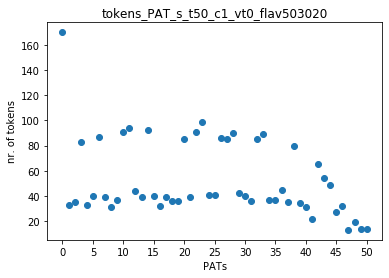

In [42]:
plt1 = pl.scatter(calculate_total_tokens_per_pat(raw_result[-1]).keys(),
           calculate_total_tokens_per_pat(raw_result[-1]).values())

pl.xticks(np.arange(0, t_step+1, 5))
pl.title("tokens_PAT_" + name)
pl.xlabel("PATs")
pl.ylabel("nr. of tokens")
pl.savefig("tokens_PAT_" + name + ".png")
pl.show()

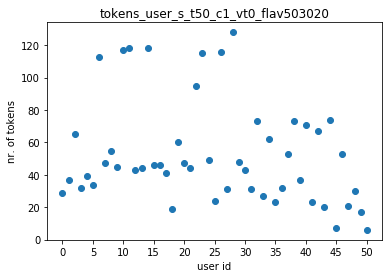

In [43]:
plt1 = pl.scatter(calculate_number_of_tokens_per_person(raw_result[-1]).keys(),
                  calculate_number_of_tokens_per_person(raw_result[-1]).values())

pl.xticks(np.arange(0, time_steps+1, 5))
pl.title("tokens_user_" + name)
pl.xlabel("user id")
pl.ylabel("nr. of tokens")
pl.savefig("tokens_user_" + name + ".png")
pl.show()

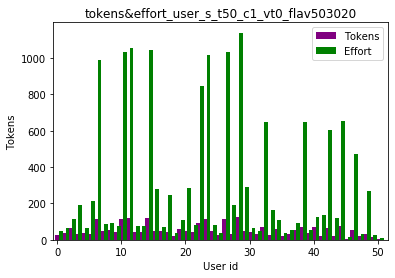

In [44]:
if PAT_atr:
    U1 = calculate_number_of_tokens_per_person(raw_result[-1]).keys()
    T = calculate_number_of_tokens_per_person(raw_result[-1]).values()
    U2 = calculate_effort_per_person(raw_result[-1]).keys()
    E = calculate_effort_per_person(raw_result[-1]).values()

    fig = pl.figure()
    ax = fig.add_subplot(111)

    N = len(U1)

    ind = np.arange(N)
    width = 0.6

    ## the bars
    rects1 = ax.bar(ind, T, width,
                color='purple',
                #yerr=TStd,
                error_kw=dict(elinewidth=2,ecolor='pink'))

    rects2 = ax.bar(ind+width, E, width,
                    color='green',
                    #yerr=EStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    ax.set_ylabel('Tokens')
    ax.set_title("tokens&effort_user_" +name)
    xTickMarks = [np.arange(0, time_steps+1, 5)]
    ax.set_xlabel('User id')
    
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Tokens', 'Effort') )

    pl.savefig("tokens&effort_user_" + name + ".png")
    pl.show()

In [45]:
def calculate_flavour_distribution(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            if pat != "reputation":
                distribution[pat] = raw_result[-1][PAT_ARGUMENTS][pat][-1]
    dist = clean_PATS_of_special_tokens(distribution)
    return dist

In [46]:
def flavours():
    arguments = raw_result[-1][PAT_ARGUMENTS]
    flavours = []
    for a in range(0, len(arguments)):
        flavours.append(raw_result[-1][PAT_ARGUMENTS][a][2])
    return flavours

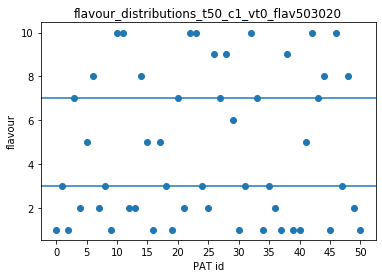

In [47]:
plt1 = pl.scatter(calculate_flavour_distribution(raw_result[-1]).keys(),
                  flavours())

pl.axhline(3)
pl.axhline(7)
pl.xticks(np.arange(0, time_steps+1, 5))
pl.title("flavour_distribution" + name)
pl.xlabel("PAT id")
pl.ylabel("flavour")
pl.savefig("flavour_distribution" + name + ".png")
pl.show()

In [48]:
def calculate_good_tokens_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            if pat != "reputation":
                #print("pat", pat)
                #print("the flavour of the PAT: ", setup.raw_result[-1][setup.PAT_ARGUMENTS][pat])
                if raw_result[-1][PAT_ARGUMENTS][pat][-1] <= 3:
                    distribution[pat] += number_of_tokens
    dist = clean_PATS_of_special_tokens(distribution)
    return dist

In [49]:
def calculate_bad_tokens_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            if pat != "reputation":
                #print(pat)
                #print(setup.raw_result[-1][setup.PAT_ARGUMENTS][pat][-1])
                if raw_result[-1][PAT_ARGUMENTS][pat][-1] > 7:
                    distribution[pat] += number_of_tokens
    dist = clean_PATS_of_special_tokens(distribution)
    return dist

In [50]:
def calculate_ok_tokens_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            if pat != "reputation":
                if raw_result[-1][PAT_ARGUMENTS][pat][-1] > 3 and raw_result[-1][PAT_ARGUMENTS][pat][-1] <=7:
                    distribution[pat] += number_of_tokens
    dist = clean_PATS_of_special_tokens(distribution)
    return dist

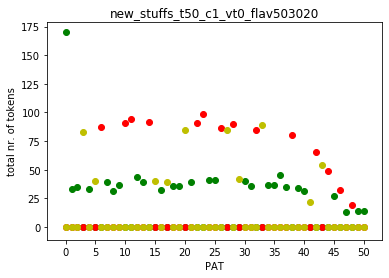

In [51]:
GT = calculate_good_tokens_per_pat(raw_result[-1]).keys()
P1 = calculate_good_tokens_per_pat(raw_result[-1]).values()
BT = calculate_bad_tokens_per_pat(raw_result[-1]).keys()
P2 = calculate_bad_tokens_per_pat(raw_result[-1]).values()
IT = calculate_ok_tokens_per_pat(raw_result[-1]).keys()
P3 = calculate_ok_tokens_per_pat(raw_result[-1]).values()

pl.scatter(GT, P1, color='g')
pl.scatter(BT, P2, color='r')
pl.scatter(IT, P3, color='y')

pl.xticks(np.arange(0, time_steps+1, 5))
pl.title("new_stuff" + name)
pl.xlabel("PAT")
pl.ylabel("total nr. of tokens")
pl.savefig("new_stuff" + name + ".png")
pl.show()